In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import seaborn as sns

from sklearn import set_config
set_config(transform_output = "pandas")

## 1. PCA for Breast Cancer

In [2]:
from sklearn.preprocessing import StandardScaler

df: pd.DataFrame
y: pd.Series

df, y = load_breast_cancer(as_frame=True, return_X_y=True)
y = y.apply(lambda x: "benign" if x else "malignant")
df = StandardScaler().fit_transform(df)

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


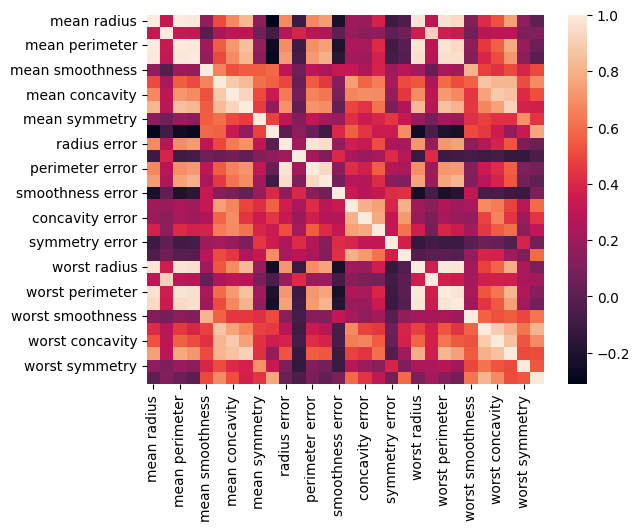

In [3]:
sns.heatmap(df.corr());

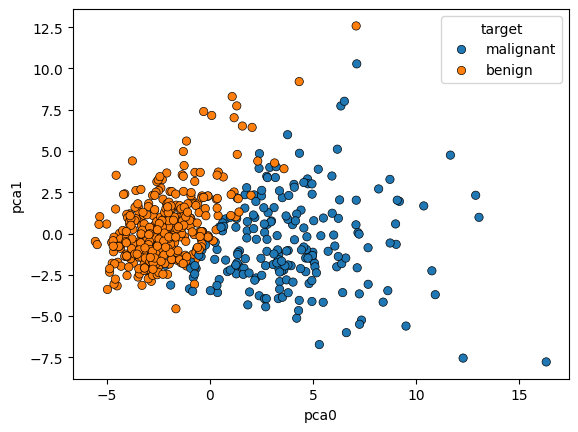

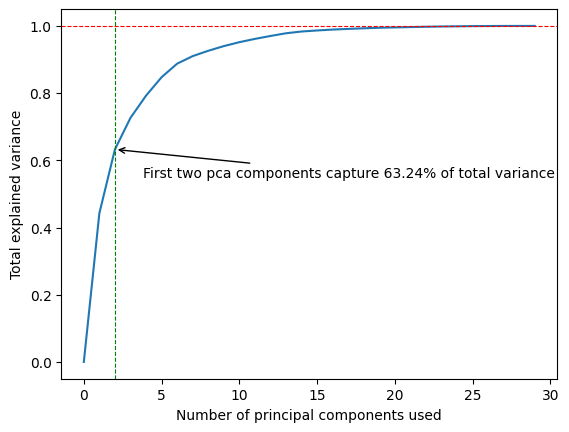

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def fit_pca_and_plot(df: pd.DataFrame, y: pd.Series) -> PCA:

    pca = PCA(n_components=len(df.columns) - 1)

    pca_df = pca.fit_transform(df)
    pca_df_target = pd.concat((pca_df, y), axis=1)

    sns.scatterplot(data=pca_df_target, x='pca0', y='pca1', hue='target', palette='tab10', edgecolor='k')
    plt.show()

    total_explained_variance = np.insert(np.cumsum(pca.explained_variance_ratio_), 0, 0)

    plt.plot(total_explained_variance)
    plt.axhline(y=1.0, color='r', linestyle='--', linewidth=0.8)
    plt.axvline(x=2, color='g', linestyle="--", linewidth=0.8)
    plt.annotate(
        text=f"First two pca components capture {100*total_explained_variance[2]:.2f}% of total variance", 
        xy=(2, total_explained_variance[2]), xytext=(20, -20),
        textcoords='offset points', 
        arrowprops=dict(arrowstyle='->')
    )

    plt.xlabel("Number of principal components used")
    plt.ylabel("Total explained variance")
    plt.show()

    return pca


fit_pca_and_plot(df, y);

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE


model = LogisticRegression(max_iter=10_000)
rfe = RFE(estimator=model, n_features_to_select=15)
rfe.fit(df, y)


better_features = df.iloc[:, rfe.support_]
worse_features = df.iloc[:, ~rfe.support_]

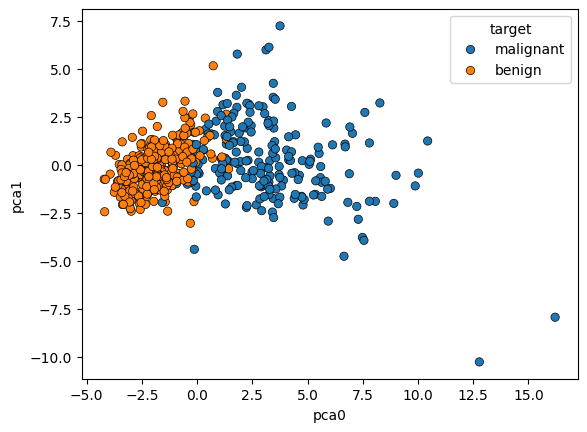

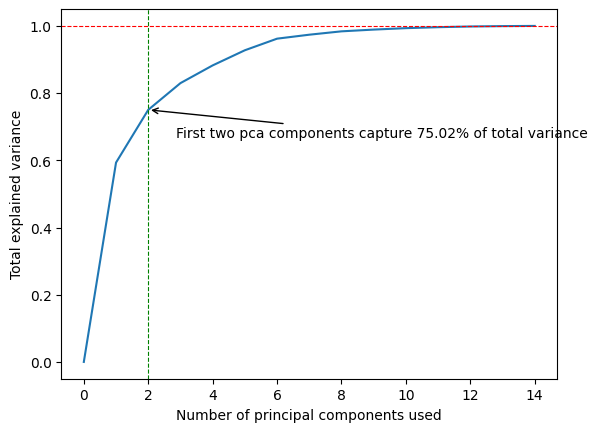

In [6]:
fit_pca_and_plot(better_features, y);

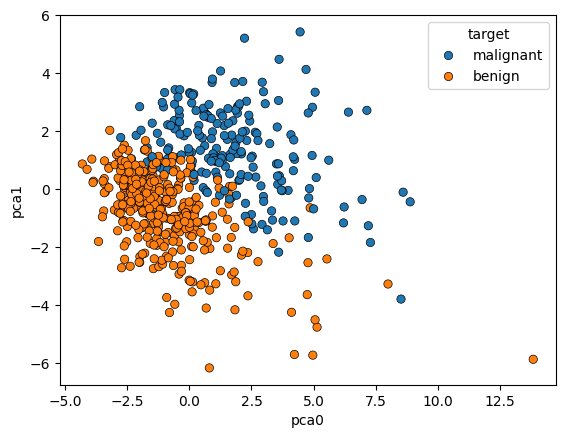

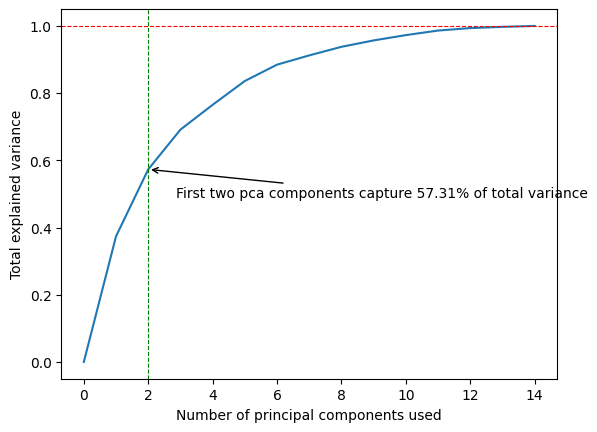

In [7]:
fit_pca_and_plot(worse_features, y);

In all three cases, applying PCA shows that the first two principal components capture most of the variance. However, for the better features, they explain 75% of the total variance, while for the worse features, they account for only 57%.

This is likely because better features contain more meaningful information and less noise. In contrast, the worse features may be more redundant or noisy.

Despite this difference in explained variance, PCA still successfully separates the classes in both cases.

## 2. KernelPCA

In [8]:
from sklearn.decomposition import KernelPCA
from itertools import product


def compute_kernel_pca_grid(df: pd.DataFrame, y: pd.Series):
    kernels = ['rbf', 'poly', 'cosine']
    gammas = [0.0001, 0.001, 0.01, 0.1, 1]

    dataframes = []

    for kernel, gamma in product(kernels, gammas):

        kernel_pca = KernelPCA(n_components=2, kernel=kernel, gamma=gamma)
        kernel_pca_df = kernel_pca.fit_transform(df)
        kernel_pca_df_target = pd.concat((kernel_pca_df, y), axis=1)

        kernel_pca_df_target['kernel'] = kernel
        kernel_pca_df_target['gamma'] = gamma
        dataframes.append(kernel_pca_df_target)

    kernel_df = pd.concat(dataframes, axis=0)

    g = sns.FacetGrid(kernel_df, row='gamma', col='kernel', hue='target', sharex=False, sharey=False)
    g.map(sns.scatterplot, 'kernelpca0', 'kernelpca1', edgecolor='k')

    fig = g.figure
    fig.set_size_inches(12, 12)
    fig.subplots_adjust(top=0.9, wspace=0.3)

    plt.show()

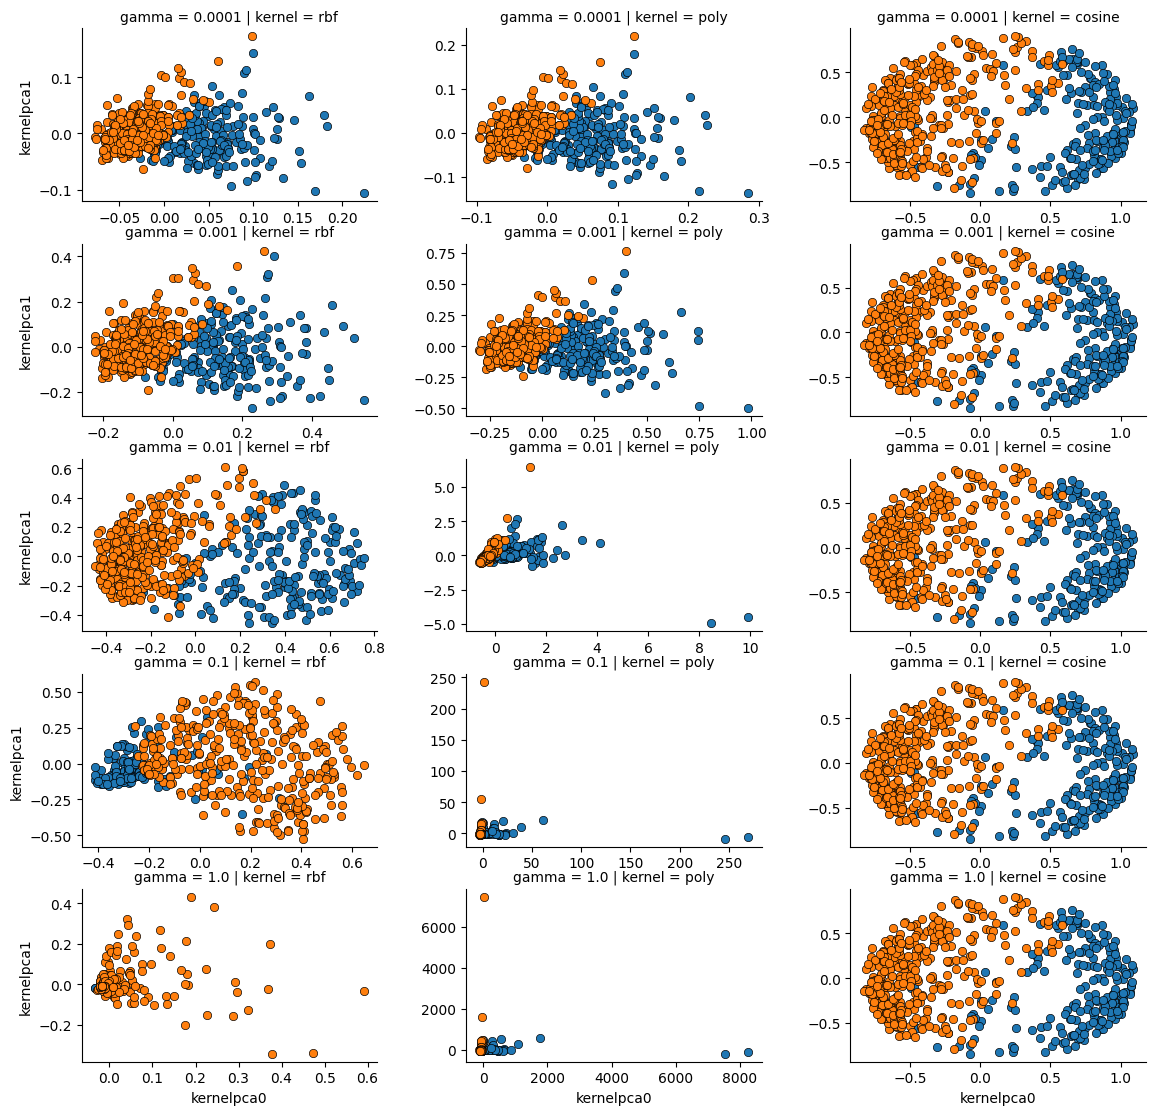

In [9]:
compute_kernel_pca_grid(df, y)

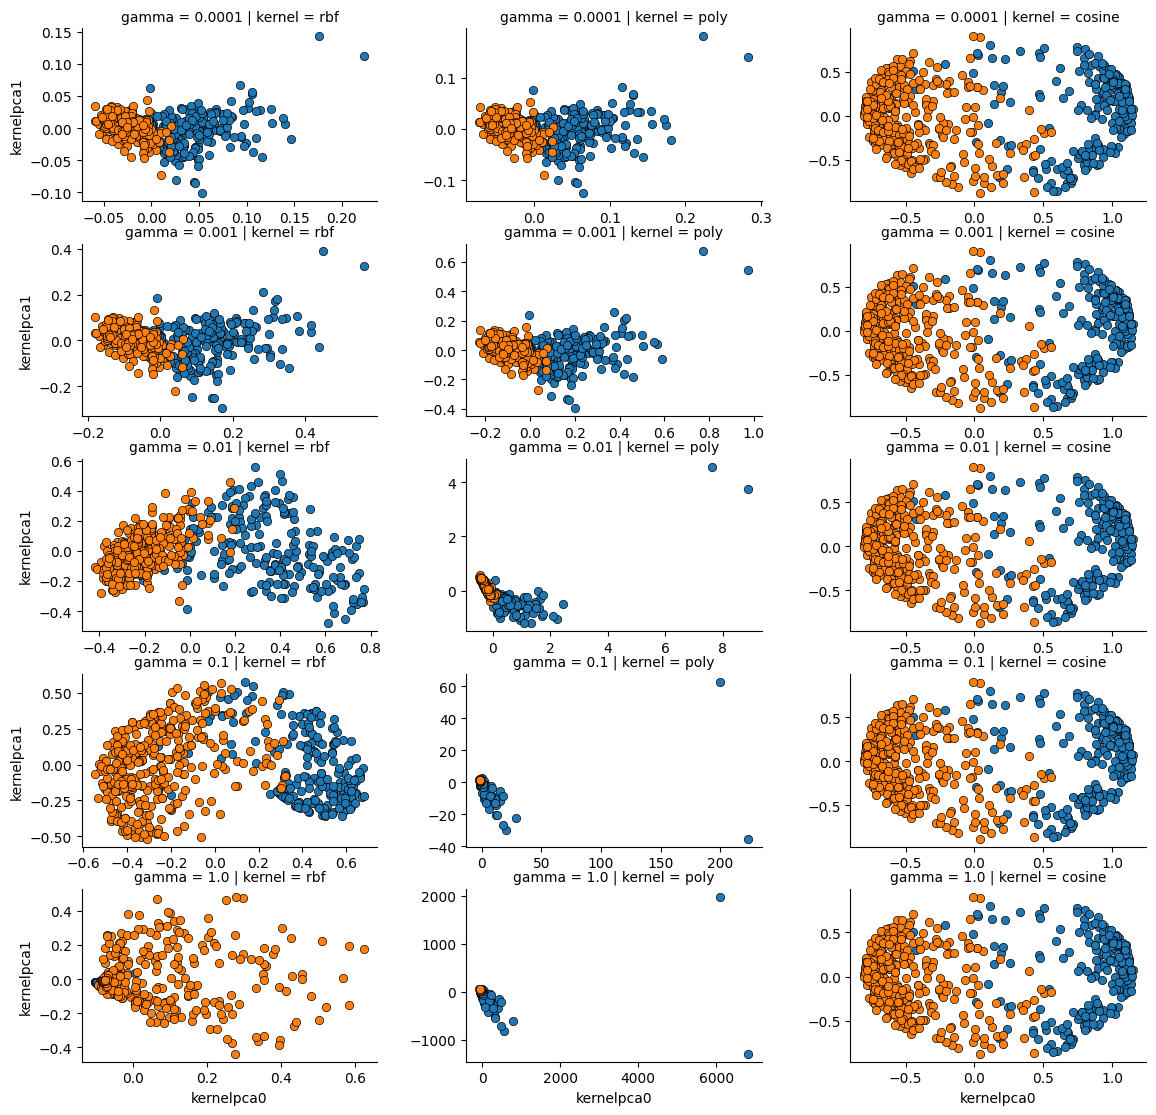

In [10]:
compute_kernel_pca_grid(better_features, y)

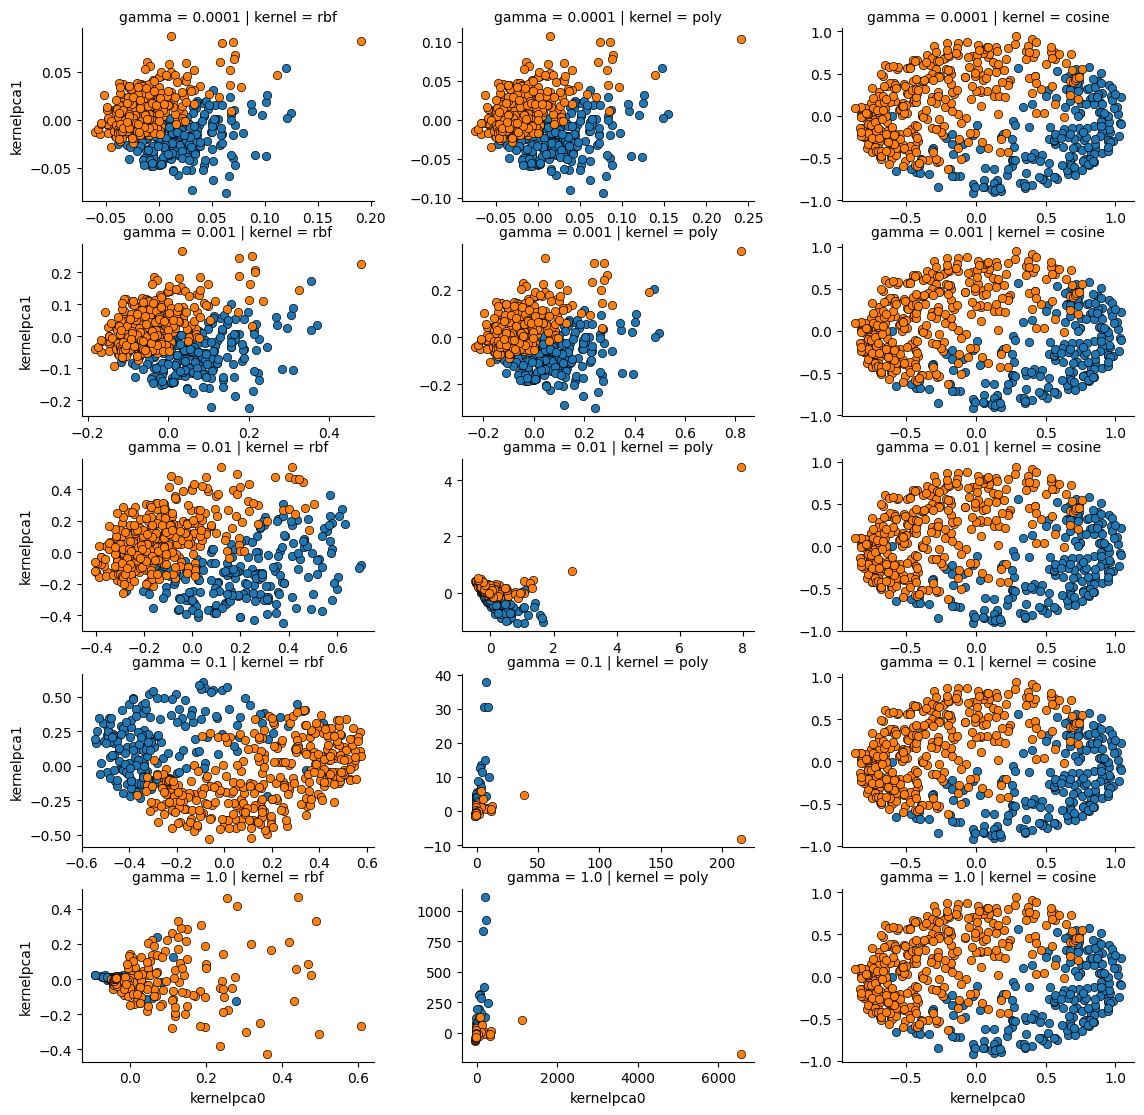

In [11]:
compute_kernel_pca_grid(worse_features, y)

We can see that different kernels could give much different results, some combinations of parameters could produce bad outcomes.

## 3. MNIST

In [12]:
from mnists import MNIST

mnist = MNIST()

MAX_IMAGES = 1000
train, y = mnist.train_images(), mnist.train_labels()

indices = np.random.permutation(len(train))[:MAX_IMAGES]
train = train[:MAX_IMAGES]
y = y[:MAX_IMAGES]

train = train.reshape(MAX_IMAGES, -1) / 255

df = StandardScaler().fit_transform(pd.DataFrame(train))
y = pd.Series(y, name="target")

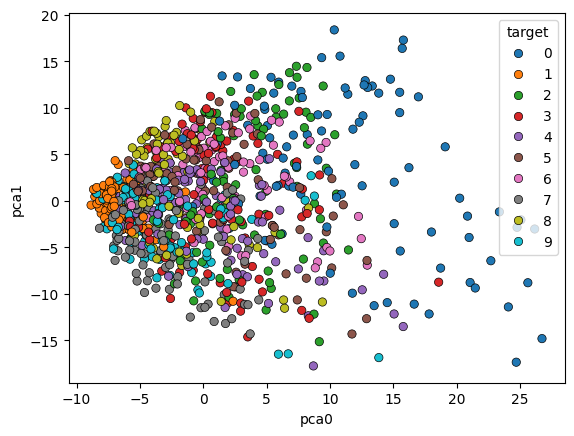

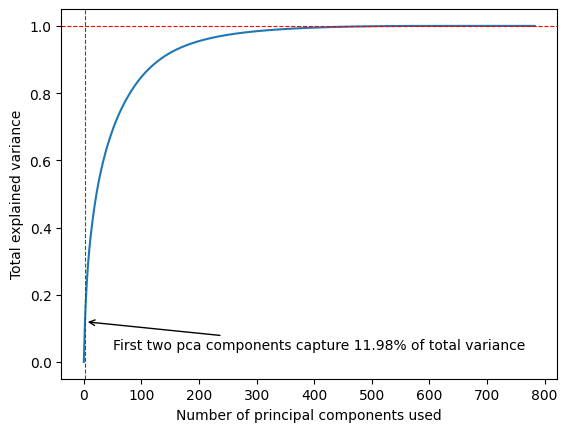

In [13]:
pca = fit_pca_and_plot(df, y)

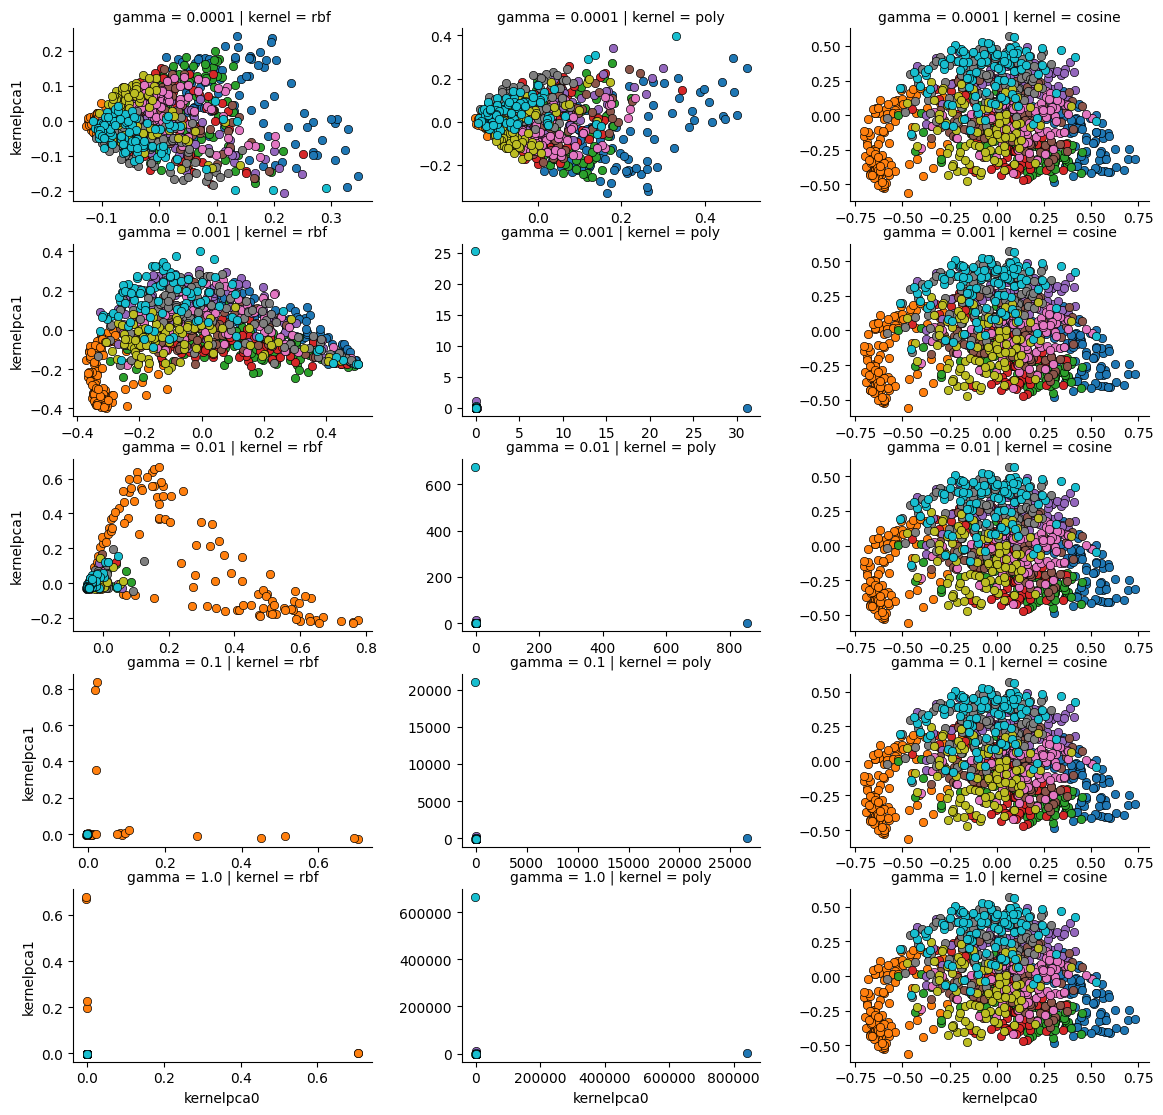

In [14]:
compute_kernel_pca_grid(df, y)

In [15]:
thresholds = [.99, .95, .90, .85]
number_of_components = []

total_explained_variance = np.cumsum(pca.explained_variance_ratio_)

for threshold in thresholds:
    comp = np.where(total_explained_variance >= threshold)[0][0].item()
    number_of_components.append(comp)

number_of_components

[342, 190, 132, 100]

In [16]:
sample_indices = np.random.randint(0, MAX_IMAGES, 16)
sample_digits = train[sample_indices]

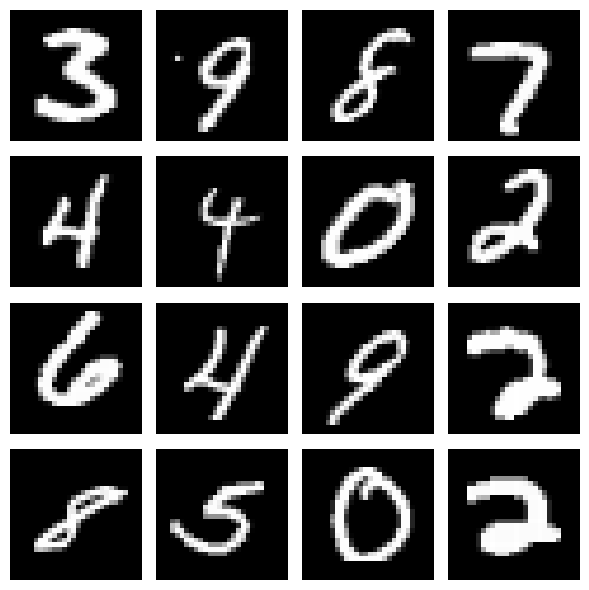

In [17]:
def draw_digits(digits: np.ndarray, rows: int, cols: int):
    fig, axes = plt.subplots(rows, cols, figsize=(6, 6))

    for i, ax in enumerate(axes.flat):
        ax.imshow(digits[i], cmap="gray")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

draw_digits(sample_digits.reshape(16, 28, 28), 4, 4)

In [18]:
def apply_inverse_transform(images_set: np.ndarray, digits: np.ndarray, n_components: int):
    pca = PCA(n_components=n_components)
    pca.fit(images_set)
    transformed = pca.transform(digits)
    inversed = pca.inverse_transform(transformed)
    return inversed

Number of components 342


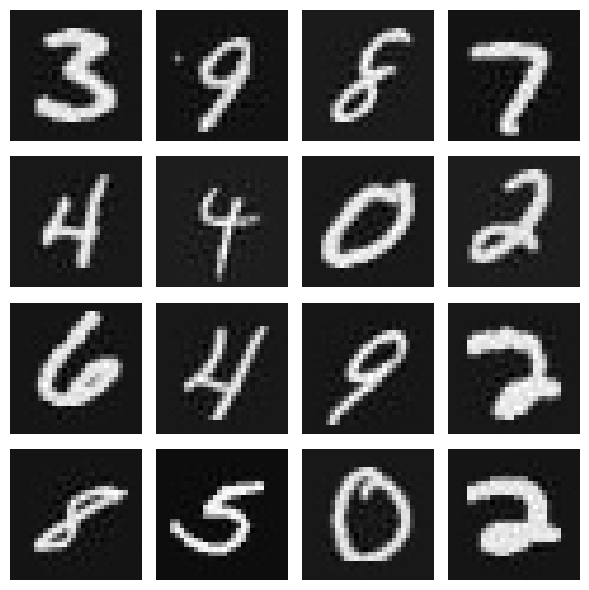

Number of components 190


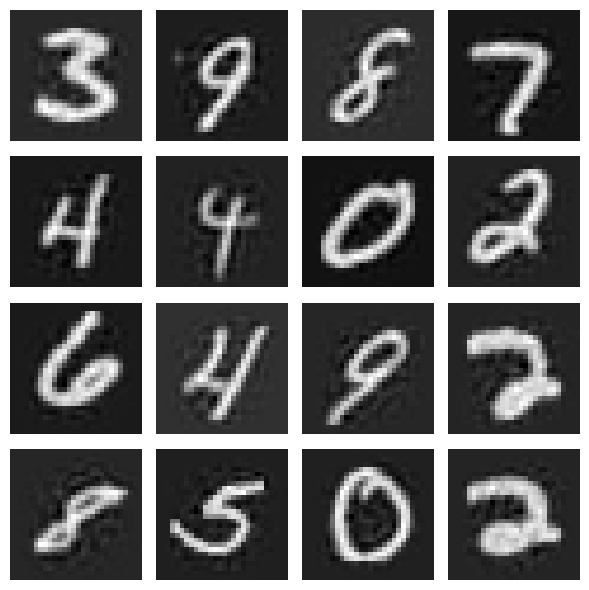

Number of components 132


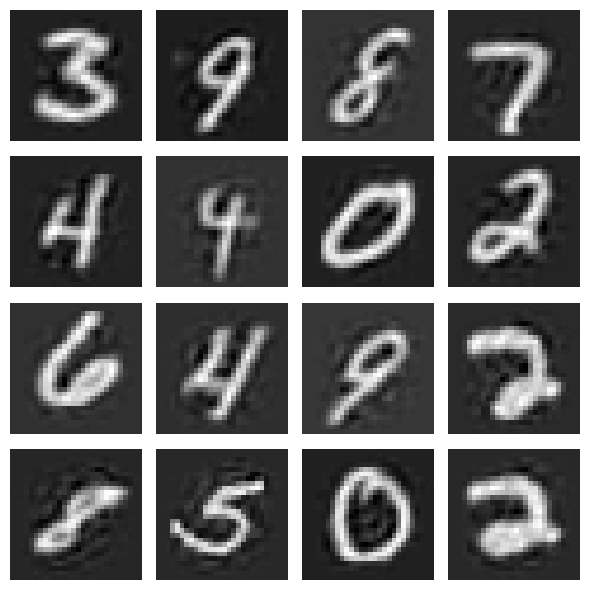

Number of components 100


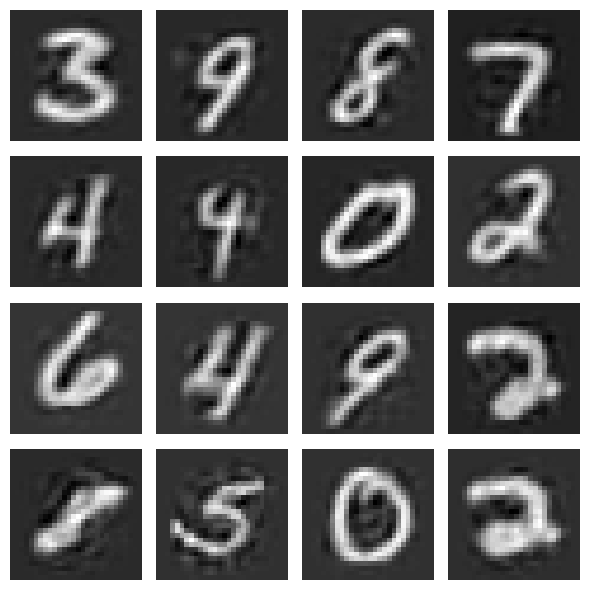

In [19]:
standard_scaler = StandardScaler()
scaled_train = standard_scaler.fit_transform(train)
scaled_digits = standard_scaler.transform(sample_digits)

for comp in number_of_components:
    print(f"Number of components {comp}")
    digits = apply_inverse_transform(scaled_train, scaled_digits, comp)
    draw_digits(standard_scaler.inverse_transform(digits).reshape(16, 28, 28), 4, 4)

In [20]:
def apply_inverse_kernel_pca(images_set: np.ndarray, digits: np.ndarray, n_components: int):
    kernel_pca = KernelPCA(n_components=n_components, kernel='rbf', gamma=1, fit_inverse_transform=True)
    kernel_pca.fit(images_set)
    transformed = kernel_pca.transform(digits)
    inversed = kernel_pca.inverse_transform(transformed)
    return inversed

Number of components 342


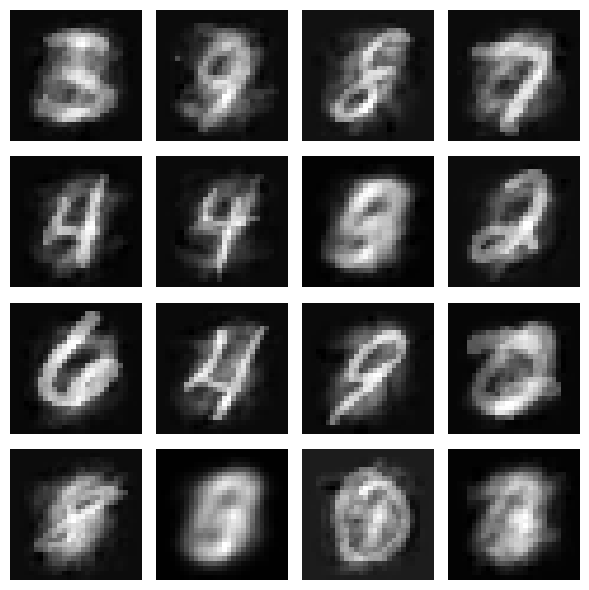

Number of components 190


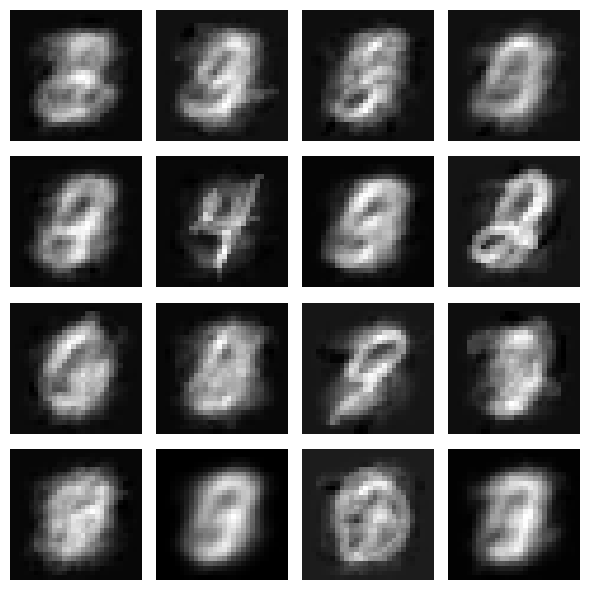

Number of components 132


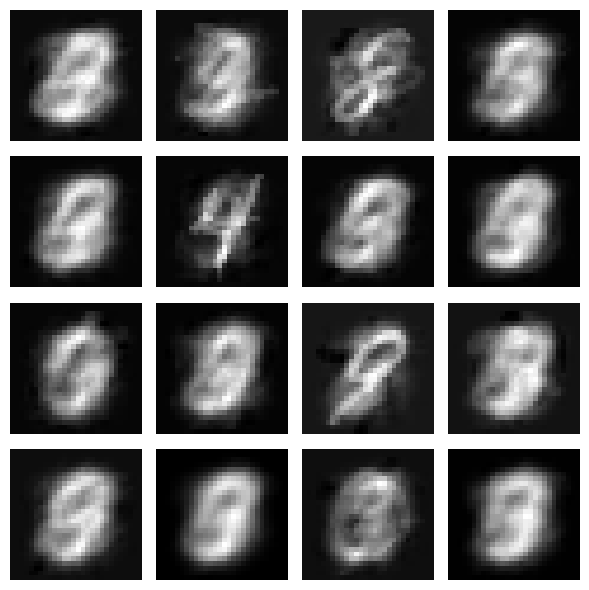

Number of components 100


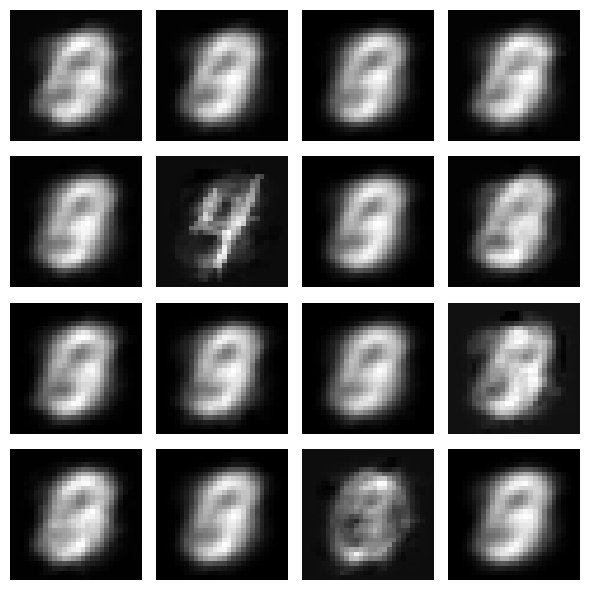

In [21]:
for comp in number_of_components:
    print(f"Number of components {comp}")
    digits = apply_inverse_kernel_pca(scaled_train, scaled_digits, comp)
    digit_images = standard_scaler.inverse_transform(digits).reshape(16, 28, 28)
    draw_digits(digit_images, 4, 4)

### Key Strengths and Limitations

PCA is a straightforward transformation that is both easy to understand and implement. It is computationally efficient and interpretable. When applied to a digit dataset, information loss was minimal—using only 100 components (approximately one-seventh of the total), we were able to reconstruct the images accurately.

However, a imitation of standard PCA is that it can only capture linear patterns and cannot handle more complicated data distributions.

The key strength of Kernel PCA comes in the ability to capture relationships more comoplicated than linear. However, this ability comes with the cost. Kernel PCA loses on interpretability. Additionally, there is no straightforward way to reconstruct projected data points. The next limitation of Kernel PCA is also its computational cost, which is quadratic with respect to the number of data points. Kernel PCA also relies on hyperparameters, such as kernel type. The search for optimal hyperparameters requires more time and cost.

### Real-World Applications

PCA is particularly useful when reducing dimensionality to speed up other machine learning algorithms. PCA is also valuable for data analysis, it might help to find some hidden strucuture in data( for example clusters ).

Kernel PCA is a better alternative in cases where the data relationships are more complicated and non-linear. When applied to MNIST, Kernel PCA provided slightly better separation of digit classes.


### Computational Complexity

For a dataset with `n` samples and `d` dimensions, standard PCA computational cost is O(n * d^2 + d^3), because innitialy it needs to compute a covariance matrix of size (d x d) and then compute its SVD.

Kernel PCA however, instead of computing covariance matrix, computes a kernel matrix, which is some function applied to every pair of data samples from a dataset. The resulting kernel matrix is of size (n x n). The eigendecomposition is then O(n^3).

This means that computational cost of Kernel PCA is cubic with respect to the number of samples. In most cases n >> d, which makes kernel PCA impossible to use.

### Suggestions for Improvement

The main drawback of Kernel PCA is its high computational cost. One way to somehow avoid it, is by using approximate methods, such as the Nystrom's method, which reduces the size of the kernel matrix by selecting a subset of data points.

## 4. Option B: Incremental PCA for Large Datasets

Fashion-MNIST is a relatively small dataset that fits easily into memory. For comparison, I load both the training and test sets. PCA and Incremental PCA are fitted on the training set, and their outputs are compared on the test set. Additionally, I extract a small sample dataset for visualization purposes.

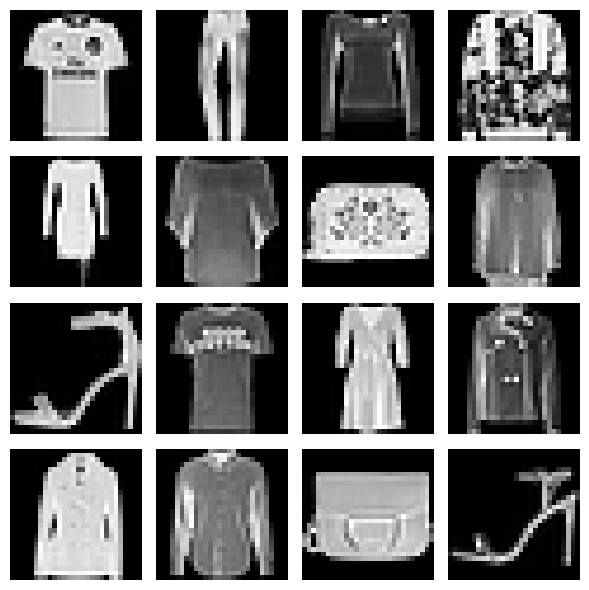

In [22]:
test_df = pd.read_csv("fashion_mnist/fashion-mnist_test.csv")
y = test_df.pop("label")

draw_digits(test_df[:16].to_numpy().reshape(16, 28, 28), 4, 4)

sample_df = test_df.iloc[::50]
sample_y = y[::50]

For IncrementalPCA I've chosen a batch size of 1000. It is recommended to standarize the data before applying pca. This can be also be achieved with incremental pca by using the StandardScaler class and `partial_fit` method that computes running mean and standard deviation.

In [23]:
import pandas as pd
from sklearn.decomposition import IncrementalPCA, PCA

BATCH_SIZE = 1000

pca = PCA(n_components=2)
ipca = IncrementalPCA(n_components=2, batch_size=BATCH_SIZE)

standard_scaler = StandardScaler()
incremental_scaler = StandardScaler()

whole_df = standard_scaler.fit_transform(pd.read_csv("fashion_mnist/fashion-mnist_train.csv").drop(columns=["label"]))
pca.fit(whole_df)

test_projected = pca.transform(standard_scaler.transform(test_df))

In [24]:
from time import perf_counter

batched_df = pd.read_csv("fashion_mnist/fashion-mnist_train.csv", chunksize=BATCH_SIZE)

differences = []
computation_time = 0
projections = []

for i, chunk in enumerate(batched_df):
    chunk.pop("label")

    start = perf_counter()
    
    incremental_scaler.partial_fit(chunk)
    chunk_scaled = incremental_scaler.transform(chunk)
    ipca.partial_fit(chunk_scaled)

    computation_time += perf_counter() - start

    test_projected_ipca = ipca.transform(incremental_scaler.transform(test_df))
    difference = np.linalg.norm(test_projected.to_numpy() - test_projected_ipca.to_numpy()) / test_projected.shape[0]
    differences.append(difference)
    

    if i % 10 == 0:
        sample_projected = ipca.transform(incremental_scaler.transform(sample_df))
        sample_projected['target'] = sample_y
        sample_projected['batch_number'] = i
        projections.append(sample_projected)
        

In [25]:
f"The computation time of the incremental PCA was approximately {computation_time:.2}s"

'The computation time of the incremental PCA was approximately 5.5s'

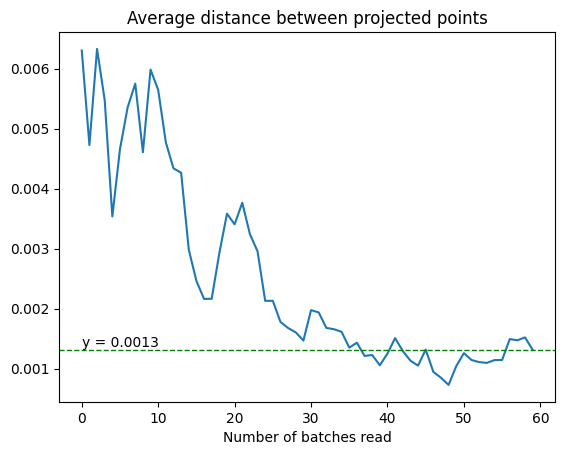

In [26]:
plt.plot(differences)

final_diff = differences[-1]

plt.axhline(final_diff, color='green', linewidth=1, linestyle="--")
plt.text(0, final_diff, f"y = {final_diff:.4f}", verticalalignment='bottom')

plt.title("Average distance between projected points")
plt.xlabel("Number of batches read")
plt.show()

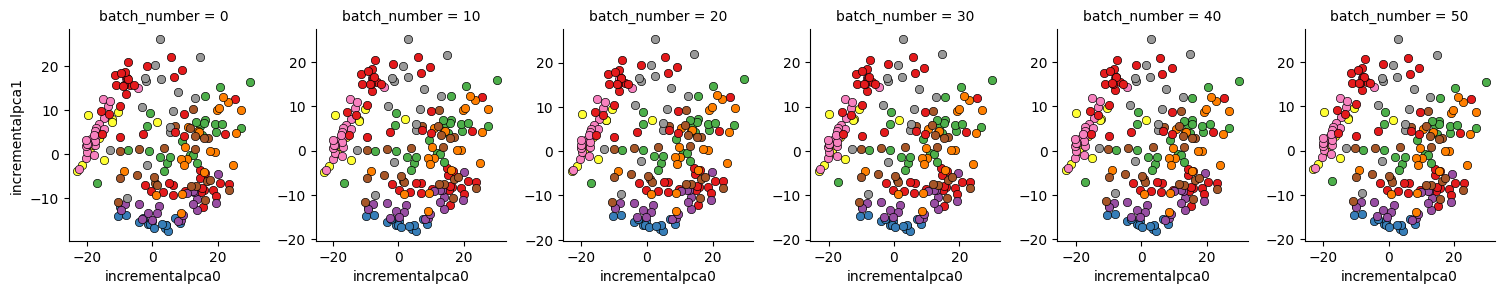

In [27]:
g = sns.FacetGrid(pd.concat(projections), col='batch_number', hue='target', palette='Set1', sharex=False, sharey=False)
g.map(sns.scatterplot, 'incrementalpca0', 'incrementalpca1', edgecolor='k')

fig = g.figure
fig.set_size_inches(15, 3)
fig.subplots_adjust(top=0.9, wspace=0.3)

plt.show()

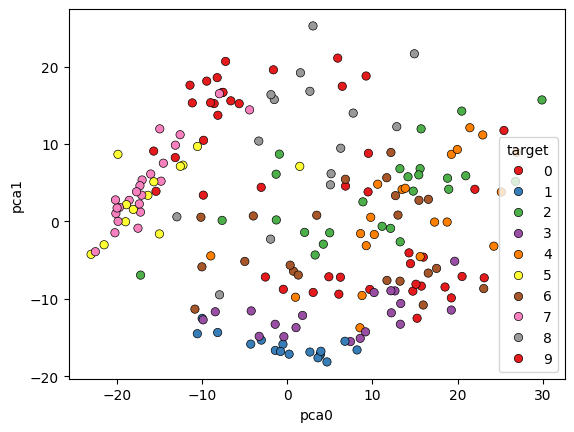

In [28]:
sample_projected = pca.transform(standard_scaler.transform(sample_df))
sample_projected['target'] = sample_y
sns.scatterplot(sample_projected, x='pca0', y='pca1', hue="target", edgecolor='k', palette='Set1');

### Key Strengths and Limitations 

Incremental PCA might be very useful when dealing with big volumes of data that cannot be read at once, or streaming data, when we don't have all the data available at once. But since the updates are iterative, the final result may not be as accurate as standard PCA. However on the Fashion Mnist example we can see the differnce was really low even after first batch. The plot of the sample points didn't really change throughout the process and was very similar to the one computed via standard PCA.

In case of the Fashion mnist, different classes are distributed uniformly across the dataset and that might be case why incremental PCA worked so well. The distribution of the batch was each time the approximation of distribution of the entire dataset. IPCA would not work so well if the distribution of the streamed data was non-stationary (For example first batch included only boots and the other only trousers).

### Real-World Applications

IPCA is very useful in many scenarios. It is very common that we do not have all the data at the beginning (like some sensor data) but we still want to somehow visualize this (for example on dashboards or other analytics platforms). The ability to iteratively adjust the model without the need of retraining it from the scratch when new data arrives is also a cool feature.

In many cases, even when we have all the data for analysis, the amount of data might be to big to fit into memory at once, so we need to rely on IPCA and load data in batches.

### Computational Complexity

For a dataset with `n` samples and `d` dimensions, standard PCA has a complexity of O(n * d^2 + d^3) like previously mentioned.

Now lets assume that the data is processed in batches of size `b`. For a single batch update it takes O(b * d^2 + d^3). We have n / b batches, so the overall complexity will be O((b*d^2 + d^3) * (n / b)) = O(n*d^2 + (n / b) * d^3). In order for the (n / b) * d^3 part to be bigger than n*d^2, the number of features d would have to be bigger than batch size, which usually not the case, so we might conclude that both algorithms have similar time complexity, while the IPCA's space complexity is obviosuly much better.


### Suggestions for Improvement

In case of streaming data, the distribution might not be stationary, it might be good idea to try apply some weighing factor, so that the model can keep updating accordingly to the drift in observed data points.